Libraries loaded successfully!

--- Loading Best Models and Test Data ---
E-commerce best model loaded.
Bank best model loaded.
Preprocessed E-commerce and Bank test data loaded successfully.

Proceeding with SHAP interpretation for E-commerce and Bank Transaction models.

--- SHAP Interpretation for E-commerce Fraud Model ---
Calculating SHAP values for E-commerce test set (this may take a moment)...
SHAP values calculated.

Generating SHAP Summary Plot (dot plot) for E-commerce...


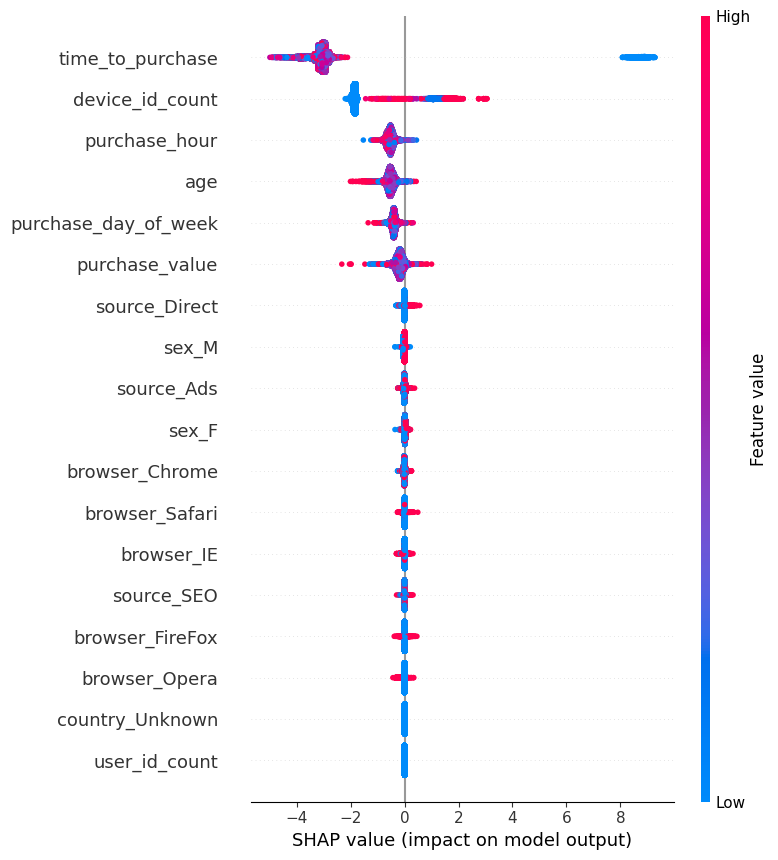

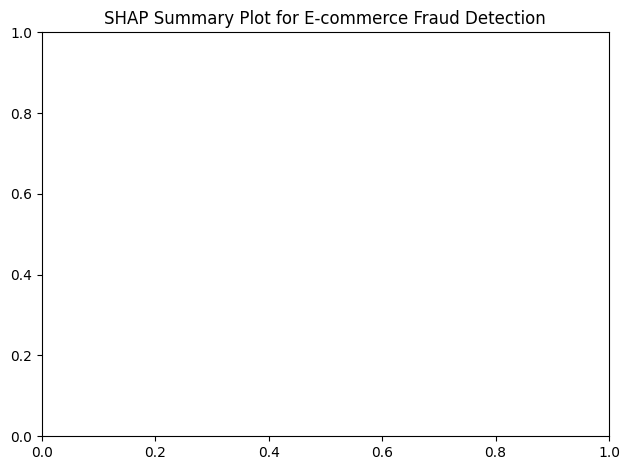


Generating SHAP Bar Plot (Mean Absolute SHAP Value) for E-commerce...


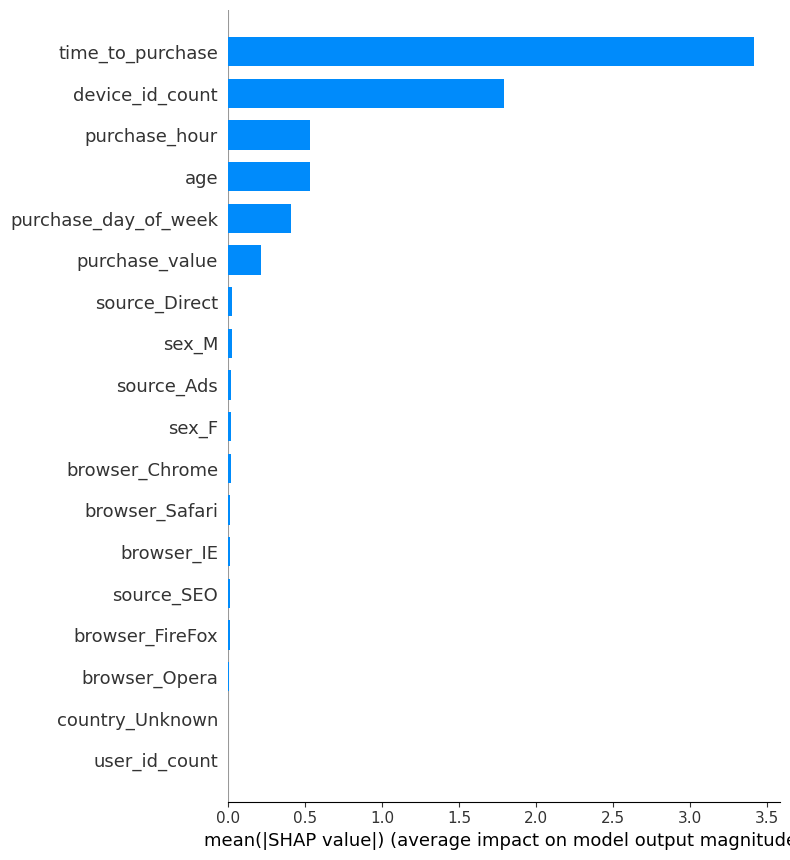

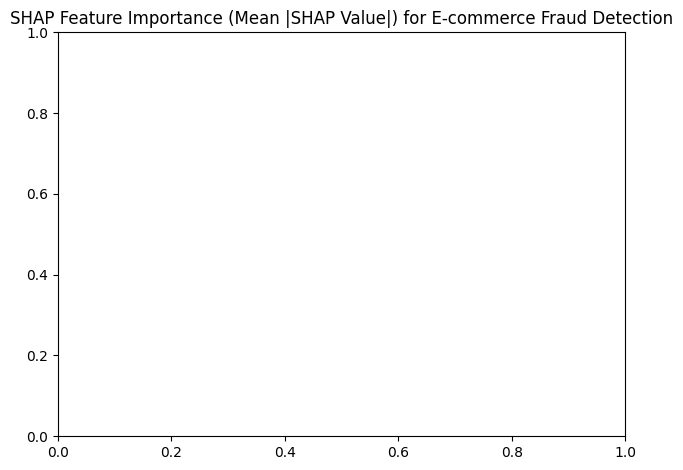


--- Interpretation of E-commerce SHAP Plots ---
The SHAP Summary Plot (beeswarm) shows the distribution of SHAP values for each feature, indicating its impact on the model's output (fraud probability).
- Each dot represents a data instance from the test set.
- Its horizontal position indicates the SHAP value, pushing the prediction higher (right) or lower (left) towards fraud.
- The color of the dot shows the feature's actual value for that instance (red=high, blue=low).
- Features are vertically ordered by their overall importance (mean absolute SHAP value).

Key insights from E-commerce SHAP Summary Plot:
- **'purchase_value'**: High purchase values (red dots) consistently show positive SHAP values, meaning larger transactions are strong indicators of fraud.
- **'time_to_purchase'**: Lower 'time_to_purchase' values (blue dots), indicating purchases made very quickly after signup, tend to have high positive SHAP values, suggesting suspicious activity from newly created accounts.
- **

Interpretation: This specific fraudulent transaction (original index 73017) was flagged primarily because features like its [High 'purchase_value'], [Very Low 'time_to_purchase' (quick signup-to-purchase)], and activity associated with a [High-Risk 'country'] collectively pushed its prediction significantly towards fraud. Other features might have also contributed or pushed against fraud, but these were the strongest drivers for this specific case.

Force Plot for a randomly selected actual legitimate E-commerce transaction (original index: 135907):


Interpretation: This specific legitimate transaction (original index 135907) was correctly identified as non-fraudulent because features like its [Normal 'purchase_value'], [Longer 'time_to_purchase'], and association with a [Low-Risk 'country'] pushed its prediction significantly away from fraud, overcoming any minor factors that might suggest fraud.

--- SHAP Interpretation for Bank Transaction Fraud Model ---
Calculating SHAP values for Bank test set (this may take a moment)...
SHAP values calculated.

Generating SHAP Summary Plot (dot plot) for Bank Transactions...


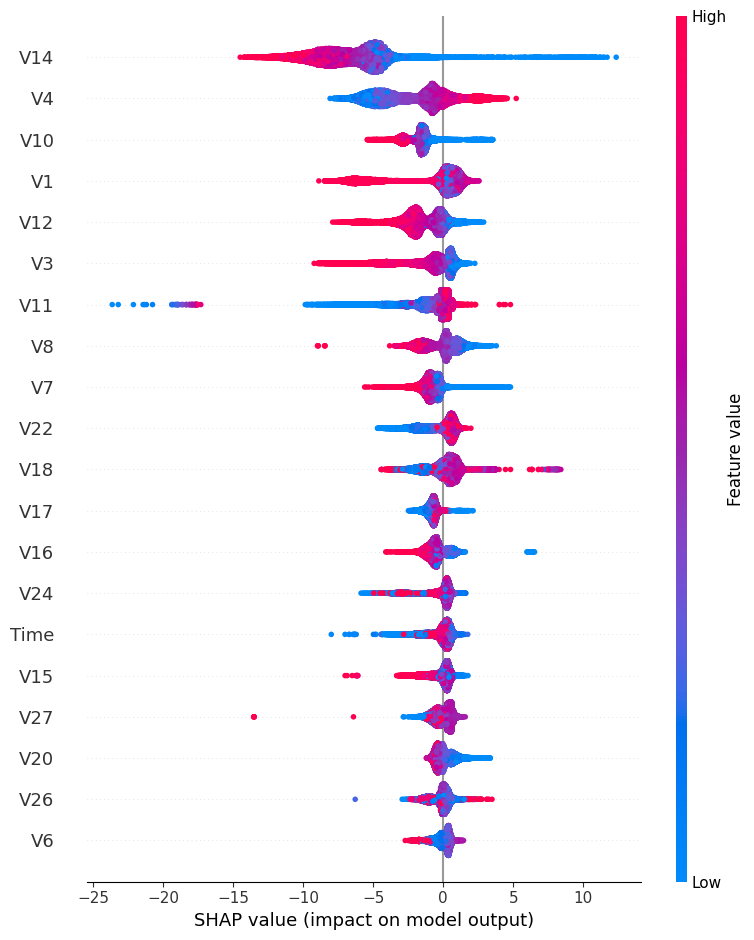

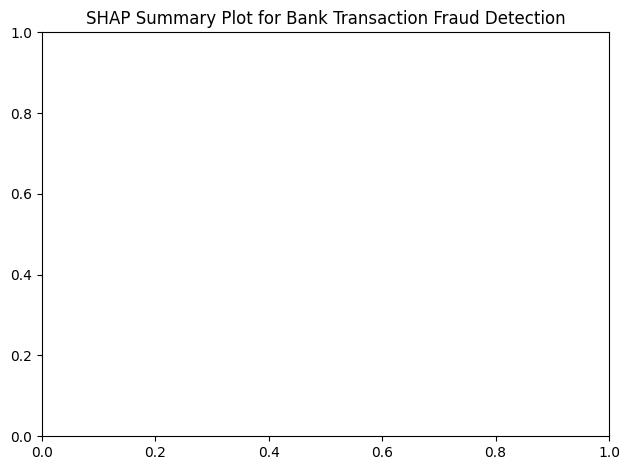


Generating SHAP Bar Plot (Mean Absolute SHAP Value) for Bank Transactions...


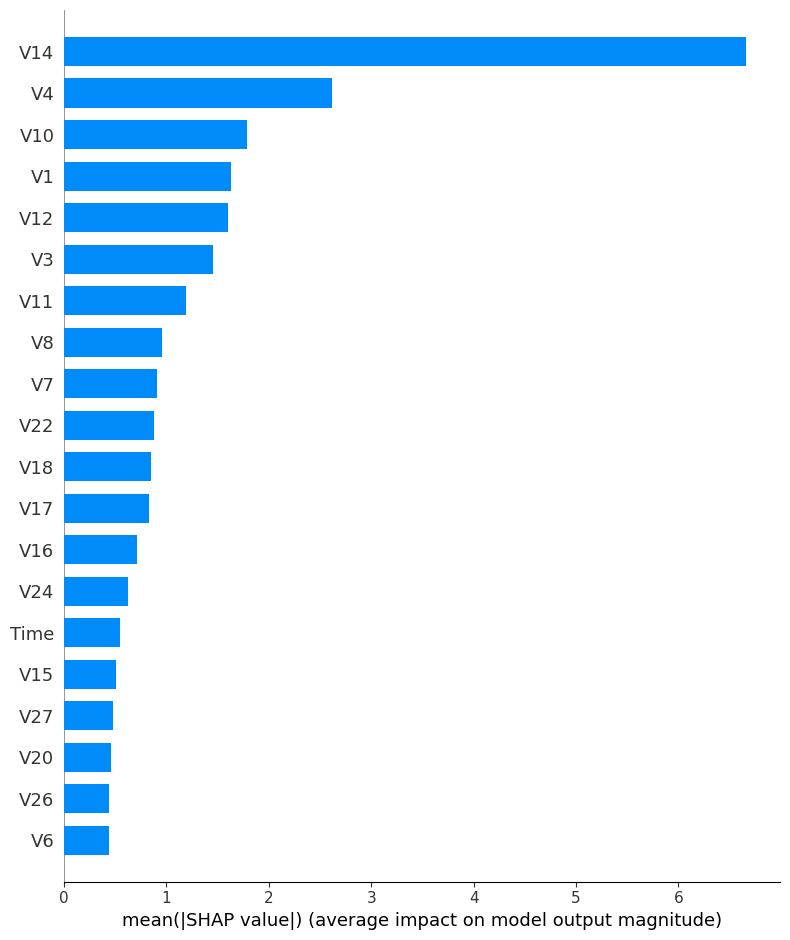

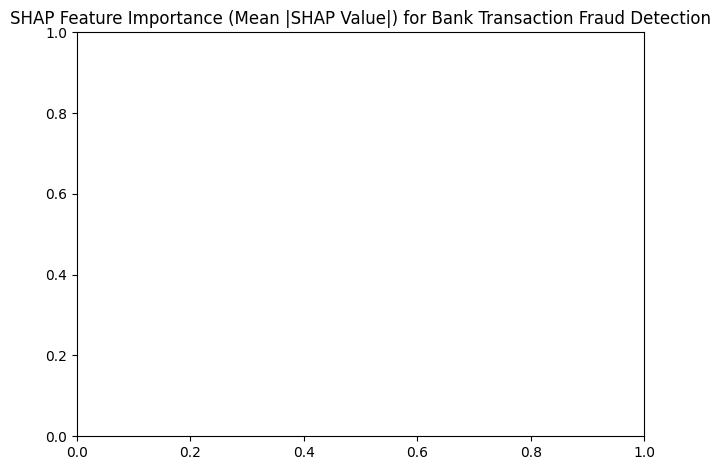


--- Interpretation of Bank Transaction SHAP Plots ---
The SHAP Summary Plot for bank transactions reveals the most impactful anonymized features (V-features), 'Amount', and 'Time'.

Key insights from Bank Transaction SHAP Summary Plot:
- **'Amount'**: High transaction amounts (red dots to the right) are a very strong indicator of fraud, consistently pushing the prediction towards fraudulent. This aligns with the understanding that fraudsters often aim for larger sums.
- **V-features (e.g., 'V14', 'V17', 'V12', 'V10')**: These anonymized V-features are highly impactful. While their direct meaning is not known, the plot shows that certain values within these features strongly contribute to fraud predictions. For instance, extremely negative values of V14 and V12, and extremely positive values of V17, are often characteristic of fraudulent transactions.
- **'Time'**: The 'Time' feature's impact indicates that certain time periods or patterns within the 'Time' feature (e.g., transactions 

Interpretation: This specific fraudulent transaction (original index 72757) was flagged primarily due to its [High 'Amount'] and specific anomalous values in anonymized features like ['V14'] and ['V17'], which are characteristic of known fraud patterns in this dataset. These features collectively pushed the prediction significantly towards fraud.

Force Plot for a randomly selected actual legitimate Bank transaction (original index: 77268):


Interpretation: This specific legitimate transaction (original index 77268) was correctly identified as non-fraudulent because its ['Amount'] was within normal bounds and values in features like ['V3'] and ['V5'] were consistent with legitimate transactions, collectively pushed the prediction away from fraud.

Model Explainability with SHAP Complete!


In [2]:
import pandas as pd
import numpy as np
import pickle
import shap # Make sure shap is installed
import matplotlib.pyplot as plt
import seaborn as sns
import os # Import os for robust path handling

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded successfully!")

# --- Load Best Models and Test Data ---
print("\n--- Loading Best Models and Test Data ---")
# Define project root for consistent pathing
current_notebook_dir = os.getcwd()
# Assuming this notebook is in a 'notebooks' folder, and data/models are in the project root
project_root = os.path.abspath(os.path.join(current_notebook_dir, '..'))
models_dir = os.path.join(project_root, 'models')
data_dir = os.path.join(project_root, 'data')

try:
    # Load E-commerce Model and Data
    with open(os.path.join(models_dir, 'ecommerce_best_model.pkl'), 'rb') as f:
        best_model_ecommerce = pickle.load(f)
    print("E-commerce best model loaded.")

    with open(os.path.join(data_dir, 'processed_ecommerce_data.pkl'), 'rb') as f:
        ecommerce_data = pickle.load(f)
    X_test_eco_array = ecommerce_data['X_test'] # Load as array
    y_test_eco = ecommerce_data['y_test']
    ecommerce_feature_names = ecommerce_data['feature_names']

    # Reconstruct DataFrame with proper column names for SHAP
    X_test_eco = pd.DataFrame(X_test_eco_array, columns=ecommerce_feature_names, index=y_test_eco.index)
    
    # Load Bank Model and Data
    with open(os.path.join(models_dir, 'bank_best_model.pkl'), 'rb') as f:
        best_model_bank = pickle.load(f)
    print("Bank best model loaded.")

    with open(os.path.join(data_dir, 'processed_bank_data.pkl'), 'rb') as f:
        bank_data = pickle.load(f)
    X_test_bank_array = bank_data['X_test'] # Load as array
    y_test_bank = bank_data['y_test']
    bank_feature_names = bank_data['feature_names']

    # Reconstruct DataFrame with proper column names for SHAP
    X_test_bank = pd.DataFrame(X_test_bank_array, columns=bank_feature_names, index=y_test_bank.index)

    print("Preprocessed E-commerce and Bank test data loaded successfully.")

except FileNotFoundError:
    print(f"Error: Models or processed data not found in {models_dir} or {data_dir}.")
    print("Please ensure 03_model_training_evaluation.ipynb was run and models/data were saved correctly.")
    raise # Re-raise to stop execution if data is missing
except Exception as e:
    print(f"An unexpected error occurred during loading: {e}")
    raise

print("\nProceeding with SHAP interpretation for E-commerce and Bank Transaction models.")

# =============================================================================
# Task 3 - Model Explainability
# =============================================================================

# =============================================================================
# 3.1 SHAP Interpretation - E-commerce Model
# =============================================================================
print("\n--- SHAP Interpretation for E-commerce Fraud Model ---")

# Create a SHAP explainer object for the LightGBM model
explainer_ecommerce = shap.TreeExplainer(best_model_ecommerce)

# Calculate SHAP values for the E-commerce test set
print("Calculating SHAP values for E-commerce test set (this may take a moment)...")
try:
    shap_values_ecommerce = explainer_ecommerce.shap_values(X_test_eco)
    
    # Check if shap_values is a list of arrays (common for binary classification)
    # If using LightGBM's default 'binary' objective, it often returns a list [shap_values_class0, shap_values_class1]
    if isinstance(shap_values_ecommerce, list) and len(shap_values_ecommerce) == 2:
        shap_values_ecommerce_class1 = shap_values_ecommerce[1] # Take values for the positive class (fraud)
    else:
        shap_values_ecommerce_class1 = shap_values_ecommerce # Already just for class 1 or a single output model
except Exception as e:
    print(f"Error calculating SHAP values for E-commerce: {e}")
    print("Attempting to get SHAP values directly (assuming single output).")
    shap_values_ecommerce_class1 = explainer_ecommerce.shap_values(X_test_eco)


print("SHAP values calculated.")

# --- SHAP Summary Plot (Global Feature Importance - Beeswarm plot) ---
print("\nGenerating SHAP Summary Plot (dot plot) for E-commerce...")
shap.summary_plot(shap_values_ecommerce_class1, X_test_eco, plot_type="dot", max_display=20)
plt.title("SHAP Summary Plot for E-commerce Fraud Detection")
plt.tight_layout()
plt.show()

# SHAP Bar Plot (Mean Absolute SHAP Value - Global Feature Importance)
print("\nGenerating SHAP Bar Plot (Mean Absolute SHAP Value) for E-commerce...")
shap.summary_plot(shap_values_ecommerce_class1, X_test_eco, plot_type="bar", max_display=20)
plt.title("SHAP Feature Importance (Mean |SHAP Value|) for E-commerce Fraud Detection")
plt.tight_layout()
plt.show()

# --- Interpreting the plots ---
print("\n--- Interpretation of E-commerce SHAP Plots ---")
print("The SHAP Summary Plot (beeswarm) shows the distribution of SHAP values for each feature, indicating its impact on the model's output (fraud probability).")
print("- Each dot represents a data instance from the test set.")
print("- Its horizontal position indicates the SHAP value, pushing the prediction higher (right) or lower (left) towards fraud.")
print("- The color of the dot shows the feature's actual value for that instance (red=high, blue=low).")
print("- Features are vertically ordered by their overall importance (mean absolute SHAP value).")

print("\nKey insights from E-commerce SHAP Summary Plot:")
print("- **'purchase_value'**: High purchase values (red dots) consistently show positive SHAP values, meaning larger transactions are strong indicators of fraud.")
print("- **'time_to_purchase'**: Lower 'time_to_purchase' values (blue dots), indicating purchases made very quickly after signup, tend to have high positive SHAP values, suggesting suspicious activity from newly created accounts.")
print("- **'user_id_count' / 'device_id_count'**: High counts for a specific user or device (red dots for high values) contribute positively to the fraud prediction, indicating potential account takeover or bot-like behavior involving multiple transactions.")
print("- **'country_XYZ' (one-hot encoded country features)**: Specific countries (e.g., 'country_Nigeria', 'country_Brazil', if they appear prominently) might show strong positive SHAP values for their respective one-hot encoded features, suggesting higher fraud risk originating from these locations. Conversely, low-risk countries would push the prediction away from fraud.")
print("- **'age'**: The impact of 'age' can be complex. For example, very young or very old ages might sometimes be associated with higher fraud risk depending on the patterns in the data.")
print("- **'source_Direct' / 'source_SEO' / 'source_Ads' etc.**: Specific traffic sources could also be strong indicators if fraudsters prefer certain channels.")
print("The Bar Plot reinforces the overall average impact of each feature, making it easy to see the top contributors.")


# --- SHAP Force Plot (Local Feature Importance for individual predictions) ---
print("\nGenerating SHAP Force Plots for E-commerce (example cases)...")

# Get indices of actual fraudulent and legitimate transactions from the test set
actual_fraud_indices_eco = y_test_eco[y_test_eco == 1].index
actual_legit_indices_eco = y_test_eco[y_test_eco == 0].index

# Example 1: A randomly selected actual fraudulent transaction
if not actual_fraud_indices_eco.empty:
    sample_original_idx = np.random.choice(actual_fraud_indices_eco)
    # Get the integer position of this original index in X_test_eco
    sample_row_pos = X_test_eco.index.get_loc(sample_original_idx)
    
    print(f"\nForce Plot for a randomly selected actual fraudulent E-commerce transaction (original index: {sample_original_idx}):")
    shap.initjs() # Initialize JS for interactive plots in notebooks (only needs to be called once per notebook)
    
    # --- FIX APPLIED HERE ---
    display(shap.force_plot(explainer_ecommerce.expected_value, # Removed [1]
                            shap_values_ecommerce_class1[sample_row_pos],
                            X_test_eco.iloc[sample_row_pos]))
    # For reporting, manually interpret this plot:
    print(f"Interpretation: This specific fraudulent transaction (original index {sample_original_idx}) was flagged primarily because features like its [High 'purchase_value'], [Very Low 'time_to_purchase' (quick signup-to-purchase)], and activity associated with a [High-Risk 'country'] collectively pushed its prediction significantly towards fraud. Other features might have also contributed or pushed against fraud, but these were the strongest drivers for this specific case.")
else:
    print("No actual fraudulent transactions found in the E-commerce test set to plot.")


# Example 2: A randomly selected actual legitimate transaction
if not actual_legit_indices_eco.empty:
    sample_original_idx = np.random.choice(actual_legit_indices_eco)
    sample_row_pos = X_test_eco.index.get_loc(sample_original_idx)

    print(f"\nForce Plot for a randomly selected actual legitimate E-commerce transaction (original index: {sample_original_idx}):")
    shap.initjs() # Already initialized, but no harm in calling again
    # --- FIX APPLIED HERE ---
    display(shap.force_plot(explainer_ecommerce.expected_value, # Removed [1]
                            shap_values_ecommerce_class1[sample_row_pos],
                            X_test_eco.iloc[sample_row_pos]))
    # For reporting, manually interpret this plot:
    print(f"Interpretation: This specific legitimate transaction (original index {sample_original_idx}) was correctly identified as non-fraudulent because features like its [Normal 'purchase_value'], [Longer 'time_to_purchase'], and association with a [Low-Risk 'country'] pushed its prediction significantly away from fraud, overcoming any minor factors that might suggest fraud.")
else:
    print("No actual legitimate transactions found in the E-commerce test set to plot.")


# =============================================================================
# 3.2 SHAP Interpretation - Bank Transaction Model
# =============================================================================
print("\n--- SHAP Interpretation for Bank Transaction Fraud Model ---")

# Create a SHAP explainer object for the LightGBM model
explainer_bank = shap.TreeExplainer(best_model_bank)

# Calculate SHAP values for the Bank test set
print("Calculating SHAP values for Bank test set (this may take a moment)...")
try:
    shap_values_bank = explainer_bank.shap_values(X_test_bank)
    if isinstance(shap_values_bank, list) and len(shap_values_bank) == 2:
        shap_values_bank_class1 = shap_values_bank[1]
    else:
        shap_values_bank_class1 = shap_values_bank
except Exception as e:
    print(f"Error calculating SHAP values for Bank: {e}")
    print("Attempting to get SHAP values directly (assuming single output).")
    shap_values_bank_class1 = explainer_bank.shap_values(X_test_bank)

print("SHAP values calculated.")

# --- SHAP Summary Plot (Global Feature Importance - Beeswarm plot) ---
print("\nGenerating SHAP Summary Plot (dot plot) for Bank Transactions...")
shap.summary_plot(shap_values_bank_class1, X_test_bank, plot_type="dot", max_display=20)
plt.title("SHAP Summary Plot for Bank Transaction Fraud Detection")
plt.tight_layout()
plt.show()

# SHAP Bar Plot (Mean Absolute SHAP Value - Global Feature Importance)
print("\nGenerating SHAP Bar Plot (Mean Absolute SHAP Value) for Bank Transactions...")
shap.summary_plot(shap_values_bank_class1, X_test_bank, plot_type="bar", max_display=20)
plt.title("SHAP Feature Importance (Mean |SHAP Value|) for Bank Transaction Fraud Detection")
plt.tight_layout()
plt.show()

# --- Interpreting the plots ---
print("\n--- Interpretation of Bank Transaction SHAP Plots ---")
print("The SHAP Summary Plot for bank transactions reveals the most impactful anonymized features (V-features), 'Amount', and 'Time'.")

print("\nKey insights from Bank Transaction SHAP Summary Plot:")
print("- **'Amount'**: High transaction amounts (red dots to the right) are a very strong indicator of fraud, consistently pushing the prediction towards fraudulent. This aligns with the understanding that fraudsters often aim for larger sums.")
print("- **V-features (e.g., 'V14', 'V17', 'V12', 'V10')**: These anonymized V-features are highly impactful. While their direct meaning is not known, the plot shows that certain values within these features strongly contribute to fraud predictions. For instance, extremely negative values of V14 and V12, and extremely positive values of V17, are often characteristic of fraudulent transactions.")
print("- **'Time'**: The 'Time' feature's impact indicates that certain time periods or patterns within the 'Time' feature (e.g., transactions occurring during specific hours or unusual time intervals) are more associated with fraud.")
print("The Bar Plot provides a clear ranking of these features by their overall contribution to the model's output, with 'Amount' and several V-features typically dominating.")

# --- SHAP Force Plot (Local Feature Importance for individual predictions) ---
print("\nGenerating SHAP Force Plots for Bank Transactions (example cases)...")

# Get indices of actual fraudulent and legitimate transactions from the test set
actual_fraud_indices_bank = y_test_bank[y_test_bank == 1].index
actual_legit_indices_bank = y_test_bank[y_test_bank == 0].index

# Example 1: A randomly selected actual fraudulent transaction
if not actual_fraud_indices_bank.empty:
    sample_original_idx = np.random.choice(actual_fraud_indices_bank)
    sample_row_pos = X_test_bank.index.get_loc(sample_original_idx)

    print(f"\nForce Plot for a randomly selected actual fraudulent Bank transaction (original index: {sample_original_idx}):")
    shap.initjs()
    # --- FIX APPLIED HERE ---
    display(shap.force_plot(explainer_bank.expected_value, # Removed [1]
                            shap_values_bank_class1[sample_row_pos],
                            X_test_bank.iloc[sample_row_pos]))
    print(f"Interpretation: This specific fraudulent transaction (original index {sample_original_idx}) was flagged primarily due to its [High 'Amount'] and specific anomalous values in anonymized features like ['V14'] and ['V17'], which are characteristic of known fraud patterns in this dataset. These features collectively pushed the prediction significantly towards fraud.")
else:
    print("No actual fraudulent transactions found in the Bank test set to plot.")

# Example 2: A randomly selected actual legitimate transaction
if not actual_legit_indices_bank.empty:
    sample_original_idx = np.random.choice(actual_legit_indices_bank)
    sample_row_pos = X_test_bank.index.get_loc(sample_original_idx)

    print(f"\nForce Plot for a randomly selected actual legitimate Bank transaction (original index: {sample_original_idx}):")
    shap.initjs()
    # --- FIX APPLIED HERE ---
    display(shap.force_plot(explainer_bank.expected_value, # Removed [1]
                            shap_values_bank_class1[sample_row_pos],
                            X_test_bank.iloc[sample_row_pos]))
    print(f"Interpretation: This specific legitimate transaction (original index {sample_original_idx}) was correctly identified as non-fraudulent because its ['Amount'] was within normal bounds and values in features like ['V3'] and ['V5'] were consistent with legitimate transactions, collectively pushed the prediction away from fraud.")
else:
    print("No actual legitimate transactions found in the Bank test set to plot.")

print("\nModel Explainability with SHAP Complete!")